In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"

from src.pipeline import Config, build_xy, FlagsDataset, CNN1D, LABELS, class_weights, train_one_epoch, plot_confusion_matrix, eval_epoch

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [3]:
def _slope(x: np.ndarray) -> float:
    """Egyszerű lineáris trend meredekség (OLS) a mintán belül."""
    x = np.asarray(x, dtype=np.float64)
    if len(x) < 2:
        return 0.0
    t = np.arange(len(x), dtype=np.float64)
    t = (t - t.mean()) / (t.std() + 1e-12)
    A = np.vstack([t, np.ones_like(t)]).T
    coef, *_ = np.linalg.lstsq(A, x, rcond=None)
    return float(coef[0])

In [4]:
def extract_features(X: np.ndarray) -> np.ndarray:
    """
    X: (N, C, L) a CNN bemenet (nálad C=4, L=256).
    Visszaad: (N, D) klasszikus ML feature vektor.
    """
    X = np.asarray(X, dtype=np.float64)
    N, C, L = X.shape
    feats = []

    for i in range(N):
        row = []
        for c in range(C):
            s = X[i, c, :]
            row += [
                float(np.mean(s)),
                float(np.std(s)),
                float(np.min(s)),
                float(np.max(s)),
                float(np.median(s)),
                _slope(s),
                float(np.mean(np.abs(s))),          # L1 energia
                float(np.mean(s**2)),               # L2 energia
            ]

            h = L // 2
            s1, s2 = s[:h], s[h:]
            row += [
                float(np.std(s1)), float(np.std(s2)),
                float(np.max(s1) - np.min(s1)),
                float(np.max(s2) - np.min(s2)),
            ]

        feats.append(row)

    return np.asarray(feats, dtype=np.float64)

Dataset: (100, 4, 256) (100,)
Feature matrix: (100, 48)

Confusion matrix:
 [[0 2 1 0 0 0]
 [0 2 2 0 0 0]
 [0 2 0 1 0 0]
 [0 0 1 1 0 1]
 [0 0 0 2 2 0]
 [0 0 0 0 2 1]]

Classification report:
                  precision    recall  f1-score   support

 Bearish Normal       0.00      0.00      0.00         3
  Bearish Wedge       0.33      0.50      0.40         4
Bearish Pennant       0.00      0.00      0.00         3
 Bullish Normal       0.25      0.33      0.29         3
  Bullish Wedge       0.50      0.50      0.50         4
Bullish Pennant       0.50      0.33      0.40         3

       accuracy                           0.30        20
      macro avg       0.26      0.28      0.26        20
   weighted avg       0.28      0.30      0.28        20



C:\Users\czofa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\czofa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\czofa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

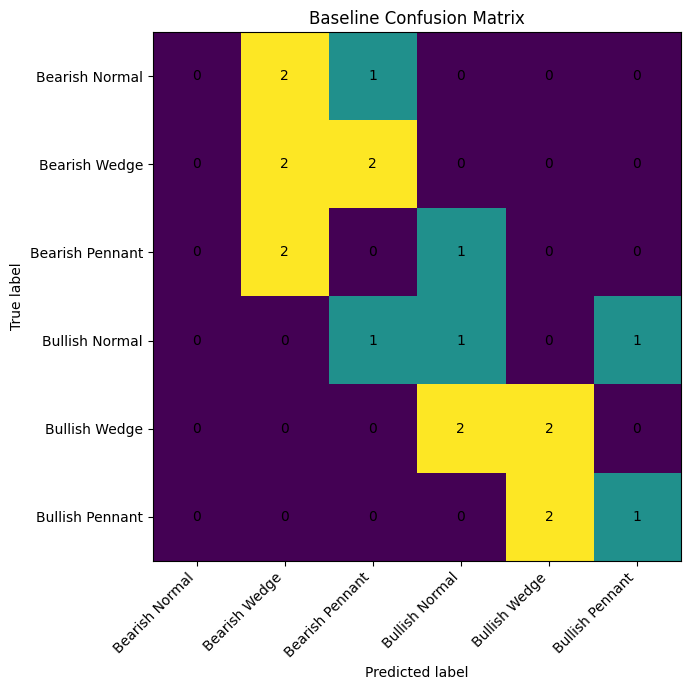

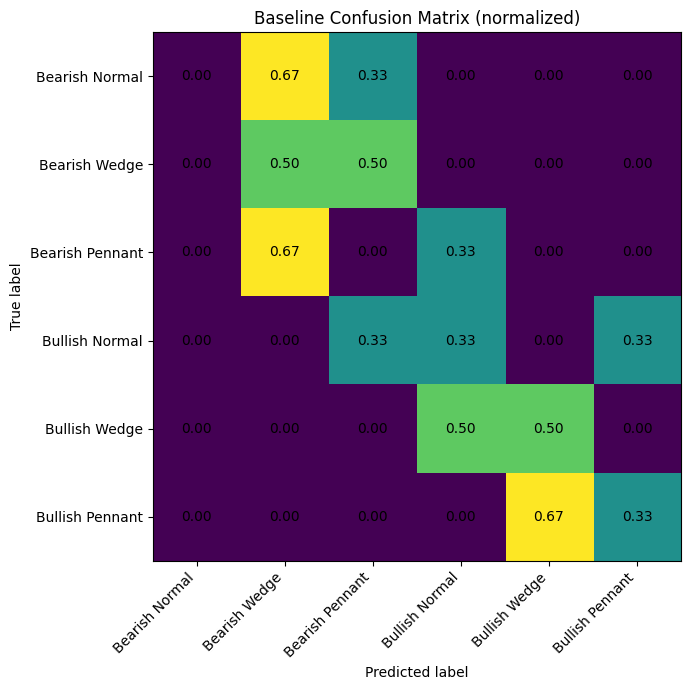

In [5]:
cfg = Config()
np.random.seed(cfg.seed)

CSV_PATH = DATA_DIR / "EURUSD_15m_007.csv"
JSON_PATH = DATA_DIR / "EURUSD_15m_007_cimkezett.json"

X, y = build_xy(CSV_PATH, JSON_PATH, L=cfg.L, pre_bars=cfg.pre_bars)
print("Dataset:", X.shape, y.shape)

F = extract_features(X)
print("Feature matrix:", F.shape)

Xtr, Xva, ytr, yva = train_test_split(
    F, y, test_size=cfg.val_size, random_state=cfg.seed, stratify=y
)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=5000,
        class_weight="balanced",
        multi_class="auto"
    ))
])

clf.fit(Xtr, ytr)
y_pred = clf.predict(Xva)

cm = confusion_matrix(yva, y_pred)
print("\nConfusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(yva, y_pred, target_names=LABELS))

# plot (nyers + normalizált)
plot_confusion_matrix(cm, LABELS, normalize=False, title="Baseline Confusion Matrix")
plot_confusion_matrix(cm, LABELS, normalize=True,  title="Baseline Confusion Matrix")

In [6]:
def run_baseline_cv(F, y, n_splits=5, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    metrics = []
    cm_sum = np.zeros((len(LABELS), len(LABELS)), dtype=int)

    for fold, (tr_idx, va_idx) in enumerate(skf.split(F, y), 1):
        Xtr, Xva = F[tr_idx], F[va_idx]
        ytr, yva = y[tr_idx], y[va_idx]

        clf = Pipeline([
            ("scaler", StandardScaler()),
            ("lr", LogisticRegression(
                max_iter=5000,
                class_weight="balanced",
                multi_class="auto"
            ))
        ])
        clf.fit(Xtr, ytr)
        pred = clf.predict(Xva)

        acc = accuracy_score(yva, pred)
        f1m = f1_score(yva, pred, average="macro", zero_division=0)
        f1w = f1_score(yva, pred, average="weighted", zero_division=0)
        cm = confusion_matrix(yva, pred, labels=np.arange(len(LABELS)))
        cm_sum += cm

        metrics.append((acc, f1m, f1w))
        print(f"[Baseline] fold {fold}: acc={acc:.3f} macroF1={f1m:.3f} weightedF1={f1w:.3f}")

    metrics = np.array(metrics)
    print("\n[Baseline] MEAN±STD")
    print(f"acc      = {metrics[:,0].mean():.3f} ± {metrics[:,0].std():.3f}")
    print(f"macroF1  = {metrics[:,1].mean():.3f} ± {metrics[:,1].std():.3f}")
    print(f"weighted = {metrics[:,2].mean():.3f} ± {metrics[:,2].std():.3f}")
    return metrics, cm_sum

In [7]:
def run_cnn_cv(X, y, cfg: Config, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=cfg.seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    metrics = []
    cm_sum = np.zeros((len(LABELS), len(LABELS)), dtype=int)

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        Xtr, Xva = X[tr_idx], X[va_idx]
        ytr, yva = y[tr_idx], y[va_idx]

        train_ds = FlagsDataset(Xtr, ytr)
        val_ds   = FlagsDataset(Xva, yva)
        train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False)

        model = CNN1D(in_ch=X.shape[1], n_classes=len(LABELS)).to(device)

        w = class_weights(ytr, n_classes=len(LABELS)).to(device)
        loss_fn = nn.CrossEntropyLoss(weight=w)
        opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

        # early stopping foldonként
        best_val = float("inf")
        best_state = None
        patience, bad = 10, 0

        for ep in range(1, cfg.epochs + 1):
            _ = train_one_epoch(model, train_loader, opt, loss_fn, device)
            va_loss, va_acc, y_true, y_pred = eval_epoch(model, val_loader, loss_fn, device)

            if va_loss < best_val - 1e-4:
                best_val = va_loss
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                bad = 0
            else:
                bad += 1
                if bad >= patience:
                    break

        if best_state is not None:
            model.load_state_dict(best_state)

        # final eval fold
        _, _, y_true, y_pred = eval_epoch(model, val_loader, loss_fn, device)

        acc = accuracy_score(y_true, y_pred)
        f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
        f1w = f1_score(y_true, y_pred, average="weighted", zero_division=0)
        cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(LABELS)))
        cm_sum += cm

        metrics.append((acc, f1m, f1w))
        print(f"[CNN] fold {fold}: acc={acc:.3f} macroF1={f1m:.3f} weightedF1={f1w:.3f}")

    metrics = np.array(metrics)
    print("\n[CNN] MEAN±STD")
    print(f"acc      = {metrics[:,0].mean():.3f} ± {metrics[:,0].std():.3f}")
    print(f"macroF1  = {metrics[:,1].mean():.3f} ± {metrics[:,1].std():.3f}")
    print(f"weighted = {metrics[:,2].mean():.3f} ± {metrics[:,2].std():.3f}")
    return metrics, cm_sum

In [8]:
cfg = Config()

CSV_PATH = DATA_DIR / "EURUSD_15m_007.csv"
JSON_PATH = DATA_DIR / "EURUSD_15m_007_cimkezett.json"

X, y = build_xy(CSV_PATH, JSON_PATH, L=cfg.L, pre_bars=cfg.pre_bars)
print("Dataset:", X.shape, y.shape)

# Baseline feature matrix
F = extract_features(X)
print("Feature matrix:", F.shape)

print("\n========== BASELINE CV ==========")
base_metrics, base_cm = run_baseline_cv(F, y, n_splits=5, seed=cfg.seed)

print("\n========== CNN CV ==========")
cnn_metrics, cnn_cm = run_cnn_cv(X, y, cfg=cfg, n_splits=5)

print("\n========== CONFUSION MATRIX SUM (5 folds) ==========")
print("[Baseline] cm sum:\n", base_cm)
print("[CNN] cm sum:\n", cnn_cm)

Dataset: (100, 4, 256) (100,)
Feature matrix: (100, 48)

========== BASELINE CV ==========
[Baseline] fold 1: acc=0.350 macroF1=0.278 weightedF1=0.317
[Baseline] fold 2: acc=0.300 macroF1=0.306 weightedF1=0.275
[Baseline] fold 3: acc=0.400 macroF1=0.345 weightedF1=0.364
[Baseline] fold 4: acc=0.500 macroF1=0.515 weightedF1=0.506
[Baseline] fold 5: acc=0.450 macroF1=0.480 weightedF1=0.483

[Baseline] MEAN±STD
acc      = 0.400 ± 0.071
macroF1  = 0.385 ± 0.095
weighted = 0.389 ± 0.091

========== CNN CV ==========


C:\Users\czofa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\czofa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\czofa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\czofa\AppData\Local\Programs\Python\P

[CNN] fold 1: acc=0.400 macroF1=0.376 weightedF1=0.370
[CNN] fold 2: acc=0.300 macroF1=0.289 weightedF1=0.260
[CNN] fold 3: acc=0.300 macroF1=0.247 weightedF1=0.270
[CNN] fold 4: acc=0.250 macroF1=0.211 weightedF1=0.202
[CNN] fold 5: acc=0.400 macroF1=0.352 weightedF1=0.356

[CNN] MEAN±STD
acc      = 0.330 ± 0.060
macroF1  = 0.295 ± 0.062
weighted = 0.292 ± 0.063

========== CONFUSION MATRIX SUM (5 folds) ==========
[Baseline] cm sum:
 [[7 2 4 1 0 1]
 [2 8 9 2 0 0]
 [3 5 3 1 2 1]
 [0 2 2 7 4 1]
 [1 1 1 1 8 7]
 [1 1 1 2 2 7]]
[CNN] cm sum:
 [[3 4 7 1 0 0]
 [7 4 7 3 0 0]
 [3 3 7 2 0 0]
 [0 1 0 6 4 5]
 [0 0 1 2 7 9]
 [0 0 1 5 2 6]]
